# Description

This notebook will compute R-FC across all possible echo pairs both following Basic and Advanced denoising.

It will then compute linear fits for the contrast between those.

Finally, it generates summary figures of how the slope and intercept adheres to the situations when BOLD or non-BOLD alone dominate the data

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os.path as osp
import subprocess
import datetime
from utils.basics import PRCS_DATA_DIR, ATLASES_DIR, ATLAS_NAME, PRJ_DIR, CODE_DIR
ATLAS_NAME = 'Power264'
ATLAS_DIR = osp.join(ATLASES_DIR,ATLAS_NAME)
from nilearn.connectome import sym_matrix_to_vec
from sfim_lib.io.afni import load_netcc
import hvplot.pandas
import seaborn as sns
import holoviews as hv
import xarray as xr
import panel as pn
from itertools import combinations_with_replacement, combinations
import matplotlib.pyplot as plt

# 1. Load Dataset Information

In [2]:
dataset_info_df = pd.read_csv(osp.join(PRJ_DIR,'resources','good_scans.txt'))
dataset_info_df = dataset_info_df.set_index(['Subject','Session'])
Nscans          = dataset_info_df.shape[0]
print('++ Number of scans: %s scans' % Nscans)
dataset_scan_list = list(dataset_info_df.index)
Nacqs = 201

++ Number of scans: 434 scans


# 2. Load Atlas Information

In [3]:
roi_info_path = osp.join(ATLAS_DIR,f'{ATLAS_NAME}.roi_info.csv')
roi_info_df   = pd.read_csv(roi_info_path)
roi_info_df.head(5)

Nrois = roi_info_df.shape[0]
Ncons = int(((Nrois) * (Nrois-1))/2)

print('++ INFO: Number of ROIs = %d | Number of Connections = %d' % (Nrois,Ncons))

++ INFO: Number of ROIs = 203 | Number of Connections = 20503


Compute Euclidean Distance between ROI centroids

In [4]:
# Select the columns that correspond to position
roi_coords_df = roi_info_df.set_index(['ROI_Name'])[['pos_R','pos_A','pos_S']]

# Convert the DataFrame to a NumPy array
roi_coords = roi_coords_df.values

# Calculate the Euclidean distance using broadcasting
roi_distance_matrix = np.sqrt(((roi_coords[:, np.newaxis] - roi_coords) ** 2).sum(axis=2))

# Convert to DataFrame
roi_distance_df = pd.DataFrame(roi_distance_matrix, index=roi_coords_df.index, columns=roi_coords_df.index)

In [5]:
roi_distance_vect = sym_matrix_to_vec(roi_distance_df.values, discard_diagonal=True)

Create list of all echo combinations and combinations of those

In [6]:
echo_pairs_tuples   = [i for i in combinations_with_replacement(['e01','e02','e03'],2)]
echo_pairs          = [('|').join(i) for i in echo_pairs_tuples]
pairs_of_echo_pairs = ['|'.join((e_x[0],e_x[1]))+'_vs_'+'|'.join((e_y[0],e_y[1])) for e_x,e_y in combinations(echo_pairs_tuples,2)]
print('Echo Pairs[n=%d]=%s' %(len(echo_pairs),str(echo_pairs)))
print('Pairs of Echo Pairs[n=%d]=%s' %(len(pairs_of_echo_pairs),str(pairs_of_echo_pairs)))

Echo Pairs[n=6]=['e01|e01', 'e01|e02', 'e01|e03', 'e02|e02', 'e02|e03', 'e03|e03']
Pairs of Echo Pairs[n=15]=['e01|e01_vs_e01|e02', 'e01|e01_vs_e01|e03', 'e01|e01_vs_e02|e02', 'e01|e01_vs_e02|e03', 'e01|e01_vs_e03|e03', 'e01|e02_vs_e01|e03', 'e01|e02_vs_e02|e02', 'e01|e02_vs_e02|e03', 'e01|e02_vs_e03|e03', 'e01|e03_vs_e02|e02', 'e01|e03_vs_e02|e03', 'e01|e03_vs_e03|e03', 'e02|e02_vs_e02|e03', 'e02|e02_vs_e03|e03', 'e02|e03_vs_e03|e03']


In [7]:
scan_names = ['_'.join((sbj,ses)) for sbj,ses in dataset_scan_list]

# 1. Load Basic Quality Information for each scan

## 1.1. Fraction of censored datapoints

In [8]:
mot_df = pd.DataFrame(index=scan_names,columns=['Percent Censored'])
mot_df.index.name = 'scan'
for i,(sbj,ses) in enumerate(tqdm(dataset_scan_list)):
    scan_name = '_'.join((sbj,ses))
    censor_path = osp.join(PRCS_DATA_DIR,sbj,f'D02_Preproc_fMRI_{ses}',f'motion_{sbj}_censor.1D')
    censor     = np.loadtxt(censor_path).astype(bool)
    mot_df.loc[scan_name,'Percent Censored'] = 100*(len(censor)-np.sum(censor))/len(censor)
    mot_df.loc[scan_name,'Percent Used']     = 100*(np.sum(censor))/len(censor)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 434/434 [00:00<00:00, 521.56it/s]


## 1.2. Fraction of BOLD-like vs. non-BOLD like data

In [9]:
tedana_df = pd.DataFrame(index=scan_names,columns=['Var. likely-BOLD','Var. unlikely-BOLD','Var. low-variance'])
tedana_df.index.name = 'scan'
for i,(sbj,ses) in enumerate(tqdm(dataset_scan_list)):
    scan_name = '_'.join((sbj,ses))
    ica_table_path = osp.join(PRCS_DATA_DIR,sbj,f'D02_Preproc_fMRI_{ses}','tedana_r01','ica_metrics.tsv')
    ica_table = pd.read_csv(ica_table_path,sep='\t')
    tedana_df.loc[scan_name,'Var. likely-BOLD'] = ica_table.set_index(['classification_tags']).loc['Likely BOLD','variance explained'].sum()
    tedana_df.loc[scan_name,'Var. unlikely-BOLD'] = ica_table.set_index(['classification_tags']).loc['Unlikely BOLD','variance explained'].sum()
    tedana_df.loc[scan_name,'Var. accepted'] = ica_table.set_index(['classification']).loc['accepted','variance explained'].sum()
    tedana_df.loc[scan_name,'Var. rejected'] = ica_table.set_index(['classification']).loc['rejected','variance explained'].sum()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 434/434 [00:02<00:00, 189.00it/s]


## 1.3. RMSE

Did not use in poster, but leave it here in case it comes useful as the project progresses.

In [11]:
rsme_df = pd.DataFrame(index=scan_names,columns=['Avg. RSME'])
rsme_df.index.name = 'scan'
for i,(sbj,ses) in enumerate(tqdm(dataset_scan_list)):
    scan_name = '_'.join((sbj,ses))
    rsme_path = osp.join(PRCS_DATA_DIR,sbj,f'D02_Preproc_fMRI_{ses}','tedana_r01','rmse.avg.txt')
    rsme = np.loadtxt(rsme_path)
    rsme_df.loc[scan_name,'Avg. RSME'] = rsme

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 434/434 [00:00<00:00, 1687.66it/s]


# 2. Pearson's FC Slope and Intercept
## 2.1. Load the data following basic denosing

We will create an xr.DataArray that will hold the slope and intercept of contrasting all 15 FC matrices for each scan separately. 

We wll also then compute the averages per scan, so that we can characterize a given scan in 2D space.

In [12]:
slope_inter_xr_all    = {}
slope_inter_xr_byscan = {}

Load ROI timeseries for all echo pairs, compute the FC-R matrices and estimate the empirical slopes and intercepts.

Then for each scan record the average slope and intercept across all possible pairs

In [14]:
%%time
slope_inter_xr_all['Basic'] = xr.DataArray(dims=['scan','echo_pairing','statistic'],
                        coords={'scan':['_'.join((sbj,ses)) for sbj,ses in dataset_scan_list],
                                'echo_pairing':pairs_of_echo_pairs,
                                'statistic':['Slope','Intercept']})

for i,(sbj,ses) in enumerate(tqdm(dataset_scan_list)):
    fc_xr_all       = xr.DataArray(dims=['pair','edge'],
                      coords={'pair':  echo_pairs,
                              'edge':  np.arange(Ncons)})
    for (e_x,e_y) in echo_pairs_tuples:
        roi_ts_path_x = osp.join(PRCS_DATA_DIR,sbj,f'D02_Preproc_fMRI_{ses}',f'errts.{sbj}.r01.{e_x}.volreg.scale.tproject_ALL.{ATLAS_NAME}_000.netts')
        roi_ts_x      = np.loadtxt(roi_ts_path_x)
        roi_ts_path_y = osp.join(PRCS_DATA_DIR,sbj,f'D02_Preproc_fMRI_{ses}',f'errts.{sbj}.r01.{e_y}.volreg.scale.tproject_ALL.{ATLAS_NAME}_000.netts')
        roi_ts_y      = np.loadtxt(roi_ts_path_y)
        aux_ts_x = pd.DataFrame(roi_ts_x, columns=roi_info_df['ROI_Name'].values)
        aux_ts_y = pd.DataFrame(roi_ts_y, columns=roi_info_df['ROI_Name'].values)
        # Compute the full correlation matrix between aux_ts_x and aux_ts_y
        aux_r   = np.corrcoef(aux_ts_x.T, aux_ts_y.T)[:aux_ts_x.shape[1], aux_ts_x.shape[1]:]
        aux_r_v = sym_matrix_to_vec(aux_r, discard_diagonal=True)
        fc_xr_all.loc['|'.join((e_x,e_y)),:] = aux_r_v

    for pair_of_pairs in combinations(fc_xr_all.pair.values,2):
        slope, intercept = np.polyfit(fc_xr_all.sel(pair=pair_of_pairs[0]),fc_xr_all.sel(pair=pair_of_pairs[1]),1)
        slope_inter_xr_all['Basic'].loc['_'.join((sbj,ses)),'_vs_'.join(pair_of_pairs),'Slope'] = slope
        slope_inter_xr_all['Basic'].loc['_'.join((sbj,ses)),'_vs_'.join(pair_of_pairs),'Intercept'] = intercept

# Average across all TE pairs
slope_inter_xr_byscan['Basic'] = slope_inter_xr_all['Basic'].mean(dim='echo_pairing')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 434/434 [01:00<00:00,  7.18it/s]

CPU times: user 31min 5s, sys: 1min, total: 32min 5s
Wall time: 1min


## 2.2. Load the data following advanced denosing

In [15]:
%%time
slope_inter_xr_all['MEICA'] =  xr.DataArray(dims=['scan','echo_pairing','statistic'],
                        coords={'scan':['_'.join((sbj,ses)) for sbj,ses in dataset_scan_list],
                                'echo_pairing':pairs_of_echo_pairs,
                                'statistic':['Slope','Intercept']})

for i,(sbj,ses) in enumerate(tqdm(dataset_scan_list)):
    fc_xr_all       = xr.DataArray(dims=['pair','edge'],
                      coords={'pair':  echo_pairs,
                              'edge':  np.arange(Ncons)})
    for (e_x,e_y) in echo_pairs_tuples:
        roi_ts_path_x = osp.join(PRCS_DATA_DIR,sbj,f'D02_Preproc_fMRI_{ses}',f'errts.{sbj}.r01.{e_x}.meica_dn.scale.tproject_ALL.{ATLAS_NAME}_000.netts')
        roi_ts_x      = np.loadtxt(roi_ts_path_x)
        roi_ts_path_y = osp.join(PRCS_DATA_DIR,sbj,f'D02_Preproc_fMRI_{ses}',f'errts.{sbj}.r01.{e_y}.meica_dn.scale.tproject_ALL.{ATLAS_NAME}_000.netts')
        roi_ts_y      = np.loadtxt(roi_ts_path_y)
        aux_ts_x = pd.DataFrame(roi_ts_x, columns=roi_info_df['ROI_Name'].values)
        aux_ts_y = pd.DataFrame(roi_ts_y, columns=roi_info_df['ROI_Name'].values)
        # Compute the full correlation matrix between aux_ts_x and aux_ts_y
        aux_r   = np.corrcoef(aux_ts_x.T, aux_ts_y.T)[:aux_ts_x.shape[1], aux_ts_x.shape[1]:]
        aux_r_v = sym_matrix_to_vec(aux_r, discard_diagonal=True)
        fc_xr_all.loc['|'.join((e_x,e_y)),:] = aux_r_v

    for pair_of_pairs in combinations(fc_xr_all.pair.values,2):
        slope, intercept = np.polyfit(fc_xr_all.sel(pair=pair_of_pairs[0]),fc_xr_all.sel(pair=pair_of_pairs[1]),1)
        slope_inter_xr_all['MEICA'].loc['_'.join((sbj,ses)),'_vs_'.join(pair_of_pairs),'Slope'] = slope
        slope_inter_xr_all['MEICA'].loc['_'.join((sbj,ses)),'_vs_'.join(pair_of_pairs),'Intercept'] = intercept

# Average across all TE pairs
slope_inter_xr_byscan['MEICA'] = slope_inter_xr_all['MEICA'].mean(dim='echo_pairing')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 434/434 [01:00<00:00,  7.16it/s]

CPU times: user 31min 7s, sys: 1min, total: 32min 8s
Wall time: 1min


# 3. Prepare Plots

## 3.1. Combine motion, BOLD variance, RMSE and Avg. Slopes and Intercepts into single Dataframe

In [16]:
aux_basic = pd.DataFrame(slope_inter_xr_byscan['Basic'].values,columns=['Slope (Basic)','Intercept (Basic)'],index=scan_names)
aux_basic.index.name = 'scan'
aux_meica = pd.DataFrame(slope_inter_xr_byscan['MEICA'].values,columns=['Slope (MEICA)','Intercept (MEICA)'],index=scan_names)
aux_meica.index.name = 'scan'
aux = pd.concat([aux_basic,aux_meica, mot_df, tedana_df],axis=1)
aux['Percent Censored'] = (aux['Percent Censored'].astype(float)+1)*2
aux['Percent Used'] = aux['Percent Used'].astype(float)
aux['Var. likely-BOLD'] = aux['Var. likely-BOLD'].astype(float)
aux['Var. unlikely-BOLD'] = aux['Var. unlikely-BOLD'].astype(float)
aux['Var. accepted'] = aux['Var. accepted'].astype(float)
aux['Var. rejected'] = aux['Var. rejected'].astype(float)

Create annotation of perpendicular dashed lines signaling the (0,1) point

In [18]:
fc_optimal_point = hv.VLine(0).opts(color='k',line_dash='dashed',line_width=1) * hv.HLine(1).opts(color='k',line_dash='dashed',line_width=1)

Show location of scans in [Slope,Intercept] plane for Basic (left) and Advanced (right) denoising

In [32]:
aux.hvplot.scatter(x='Intercept (Basic)',y='Slope (Basic)',aspect='square',s='Percent Censored',hover_cols=['scan'], cmap='viridis', c='Var. accepted',alpha=.7,xlim=(-0.02,0.15),ylim=(0.45,1.1)).opts(fontscale=1.5, colorbar_opts={'title':'% BOLD Variance:'})*fc_optimal_point + \
aux.hvplot.scatter(x='Intercept (MEICA)',y='Slope (MEICA)',aspect='square',s='Percent Censored',hover_cols=['scan'], cmap='viridis', c='Var. accepted',alpha=.7,xlim=(-0.02,0.15),ylim=(0.45,1.1)).opts(fontscale=1.5, colorbar_opts={'title':'% BOLD Variance:'})*fc_optimal_point

:Layout
   .Overlay.I  :Overlay
      .Scatter.I :Scatter   [Intercept (Basic)]   (Slope (Basic),Var. accepted,Percent Censored,scan)
      .VLine.I   :VLine   [x,y]
      .HLine.I   :HLine   [x,y]
   .Overlay.II :Overlay
      .Scatter.I :Scatter   [Intercept (MEICA)]   (Slope (MEICA),Var. accepted,Percent Censored,scan)
      .VLine.I   :VLine   [x,y]
      .HLine.I   :HLine   [x,y]

## 3.2. Same information in a single figure in the form of a vector field

For that, I need to first compute the magnitude and angle of the vectors.

Also, how much they are getting closer towards the ideal (0,1) point. This for coloring the vectors

In [33]:
aux['u']     = aux['Intercept (MEICA)'] - aux['Intercept (Basic)']
aux['v']     = aux['Slope (MEICA)'] - aux['Slope (Basic)']
aux['mag']   = np.sqrt(aux['u']**2 + aux['v']**2)
aux['angle'] = (np.pi/2.) - np.arctan2(aux['u']/aux['mag'], aux['v']/aux['mag'])
aux['Aproachment'] = np.sqrt((aux['Intercept (Basic)'] - 0)**2+(aux['Slope (Basic)'] - 1)**2) - np.sqrt((aux['Intercept (MEICA)'] - 0)**2+(aux['Slope (MEICA)'] - 1)**2)

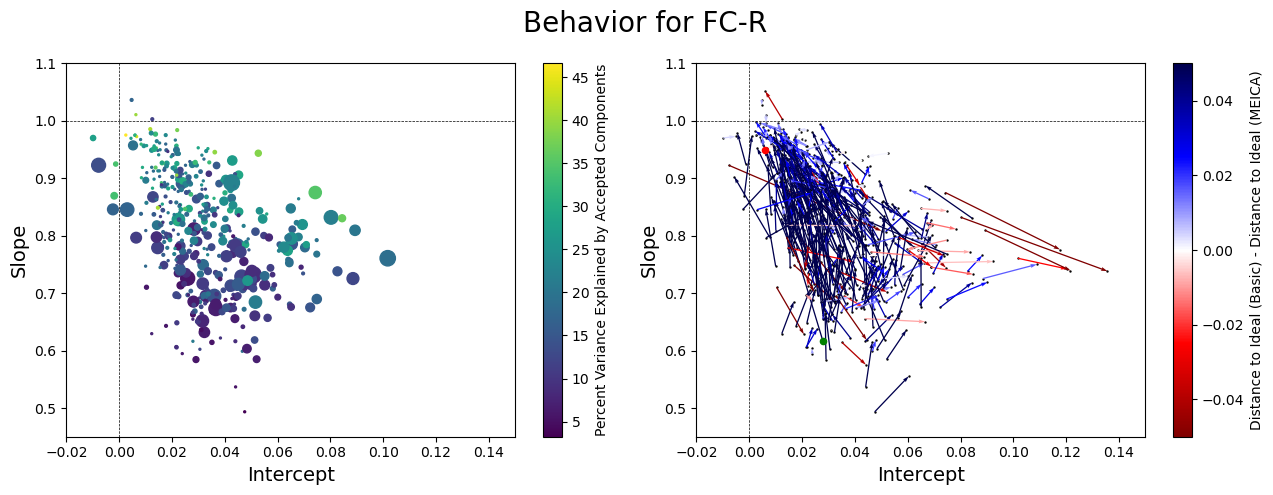

In [36]:
fig,axs=plt.subplots(1,2,figsize=(13, 5))
basic_scat      = axs[0].scatter(aux['Intercept (Basic)'],aux['Slope (Basic)'],c=aux['Var. accepted'],s=aux['Percent Censored'])
basic_scat_cbar = plt.colorbar(basic_scat)
basic_scat_cbar.set_label('Percent Variance Explained by Accepted Components',fontsize=10)
axs[0].axvline(0,c='k',linestyle='--', linewidth=0.5)
axs[0].axhline(1,c='k',linestyle='--', linewidth=0.5)
axs[0].set_ylim(.45,1.1)
axs[0].set_xlim(-0.02,0.15)
axs[0].set_xlabel('Intercept', fontsize=14)
axs[0].set_ylabel('Slope', fontsize=14)
axs[1].scatter(aux['Intercept (Basic)'],aux['Slope (Basic)'],color='k',s=0.5,)
axs[1].scatter(aux['Intercept (MEICA)'],aux['Slope (MEICA)'],color='k',s=0.5)
qiv = axs[1].quiver(aux['Intercept (Basic)'],aux['Slope (Basic)'],aux['u'], aux['v'], aux['Aproachment'], angles='xy', scale_units='xy', scale=1, cmap='seismic_r', clim=(-0.05,0.05))
qiv_cbar = plt.colorbar(qiv)
qiv_cbar.set_label('Distance to Ideal (Basic) - Distance to Ideal (MEICA)',fontsize=10)

axs[1].set_ylim(.45,1.1)
axs[1].set_xlim(-0.02,0.15)
axs[1].axvline(0,c='k',linestyle='--', linewidth=0.5)
axs[1].axhline(1,c='k',linestyle='--', linewidth=0.5)
axs[1].set_xlabel('Intercept', fontsize=14)
axs[1].set_ylabel('Slope', fontsize=14)
fig.suptitle("Behavior for FC-R", fontsize=20)

axs[1].scatter(aux.loc['sub-137_ses-1','Intercept (Basic)'],aux.loc['sub-137_ses-1','Slope (Basic)'],c='g',s=20)
axs[1].scatter(aux.loc['sub-137_ses-1','Intercept (MEICA)'],aux.loc['sub-137_ses-1','Slope (MEICA)'],c='r',s=20)
fig.tight_layout()